# Analyzing the Shopify Global Catalogue Dataset

Below are all the dependencies we need.

In [ ]:
from datasets import load_dataset
from collections import Counter
from matplotlib import pyplot as plt
from io import BytesIO
import base64
import pprint
from mlperf_inf_mm_q3vl.task import Task
from openai import AsyncOpenAI, DefaultAioHttpClient
import numpy as np
import json
import time
import asyncio

Load the dataset from HuggingFace.

In [ ]:
dataset = load_dataset(
    "Shopify/the-catalogue-public-beta",
    revision="main",
    split="train+test",
    token="...",
)
print(dataset)

Dataset({
    features: ['product_title', 'product_description', 'product_image', 'potential_product_categories', 'ground_truth_brand', 'ground_truth_is_secondhand', 'ground_truth_category'],
    num_rows: 48289
})


Display a sample from the dataset:

In [ ]:
sample_index = 12345
print(f"An example product at the index {sample_index}:")
for key, value in dataset[sample_index].items():
    print(f"==========\n{key}: {value}")
    if isinstance(value, list):
        print(f"{len(value)=}")
plt.imshow(dataset[sample_index]["product_image"])
plt.axis('off')
plt.title(f"Example Product Image at index {sample_index}")
plt.show()

Most samples have 8 or 9 potential product categories:

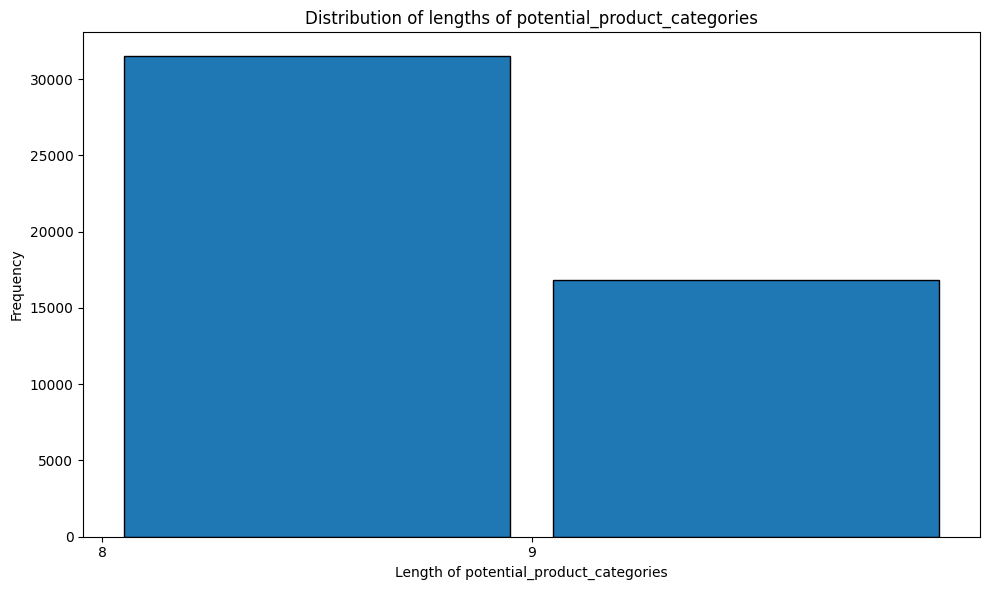

In [3]:
# Plot histogram of the length of potential_product_categories in the split split
def plot_len_potential_product_categories(dataset):
    lengths = [len(product.get("potential_product_categories", [])) for product in dataset]

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2), edgecolor='black', rwidth=0.9)
    plt.xlabel('Length of potential_product_categories')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of lengths of potential_product_categories')
    plt.xticks(range(min(lengths), max(lengths) + 1))
    plt.tight_layout()
    plt.show()

plot_len_potential_product_categories(dataset)

The correct categories are randomly distributed in the lists of potential product categories:

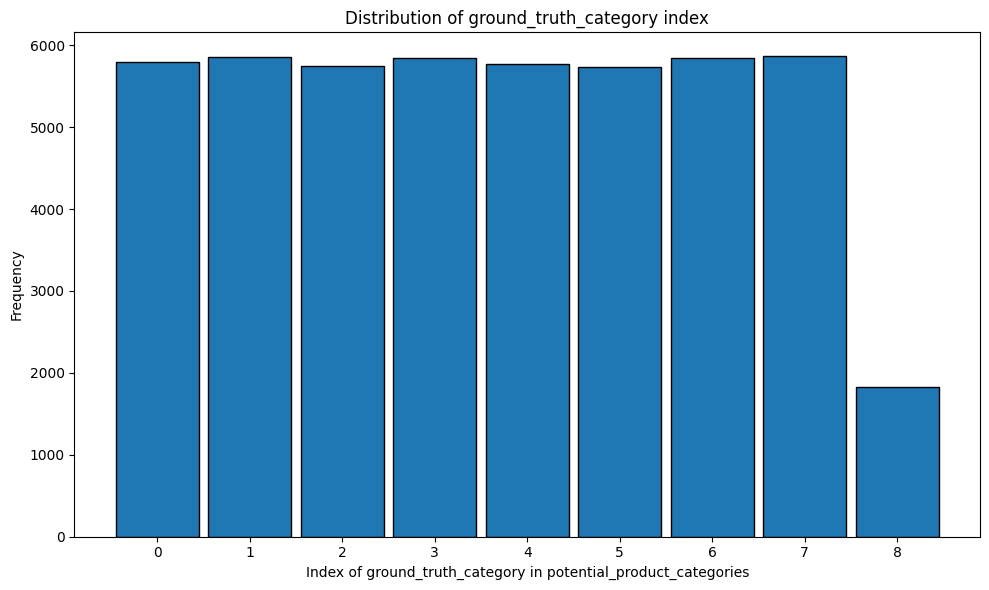

In [4]:
def plot_indices_ground_truth_category_in_potential_product_categories(dataset):
    # Plot histogram of positions/indices of ground_truth_category in potential_product_categories

    # Collect the indices
    position_indices = []
    for product in dataset:
        gt = product.get("ground_truth_category")
        pot = product.get("potential_product_categories", [])
        idx = pot.index(gt)
        position_indices.append(idx)

    # Plot the histogram
    plt.figure(figsize=(10,6))
    plt.hist(position_indices, bins=np.arange(-0.5, max(position_indices)+1.5, 1), edgecolor='black', rwidth=0.9)
    plt.xlabel("Index of ground_truth_category in potential_product_categories")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of ground_truth_category index")
    plt.xticks(range(min(position_indices), max(position_indices)+1))
    plt.tight_layout()
    plt.show()

plot_indices_ground_truth_category_in_potential_product_categories(dataset)

We wanna take a look into the distribution of the various fields.

In [5]:

def count_and_plot_top_n(dataset, value_fn, field_label, n=10):
    """
    Counts occurrences using a custom value extraction function.

    Args:
        dataset: The HuggingFace dataset as returned by load_dataset.
        split: The split of the dataset to use.
        value_fn: A function (product_dict) -> value, to extract the field to be counted.
        field_label: String label to describe the field when printing (default: function name or 'field').
        n: Number of top frequent items to print.
    """
    values = [value_fn(product) for product in dataset]
    # Remove Nones (missing values)
    values = [v for v in values if v is not None]
    counts = Counter(values)
    top_n = counts.most_common(n)
    import matplotlib.pyplot as plt

    # Use only the top n keys and their counts for the histogram
    keys = [key for key, _ in top_n]
    values = [count for _, count in top_n]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(keys)), values, tick_label=[str(k) for k in keys])
    plt.title(f"Top {n} {field_label}")
    plt.xlabel(f"{field_label.title()}")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    assert counts.total() == len(dataset), f"Counts total {counts.total()} does not match dataset length {len(dataset)}"

The distribution of secondhand vs. new products are:

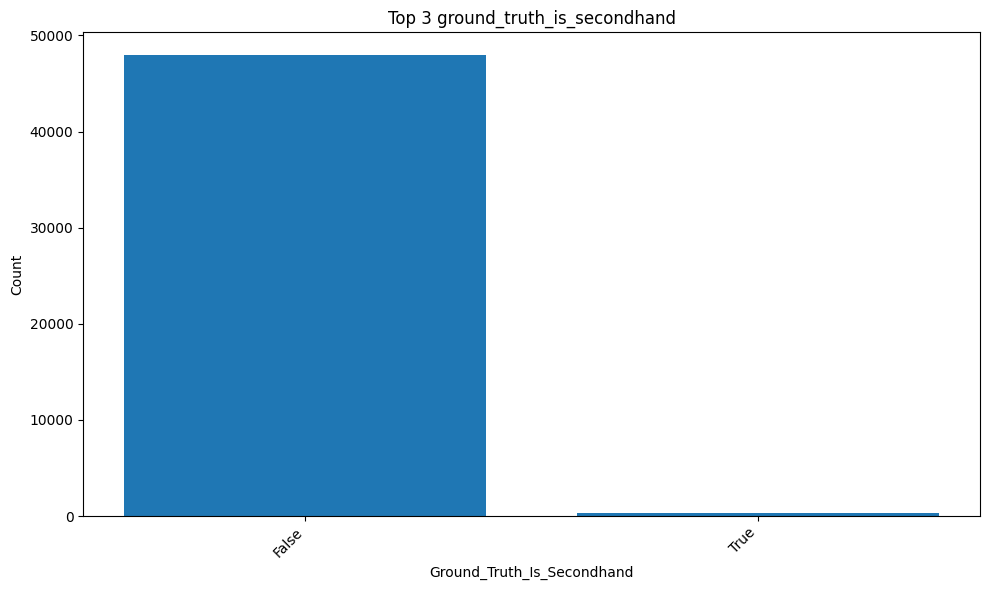

In [6]:
count_and_plot_top_n(dataset, lambda p: p.get('ground_truth_is_secondhand'), field_label='ground_truth_is_secondhand', n=3)

The distribution of the image sizes are:

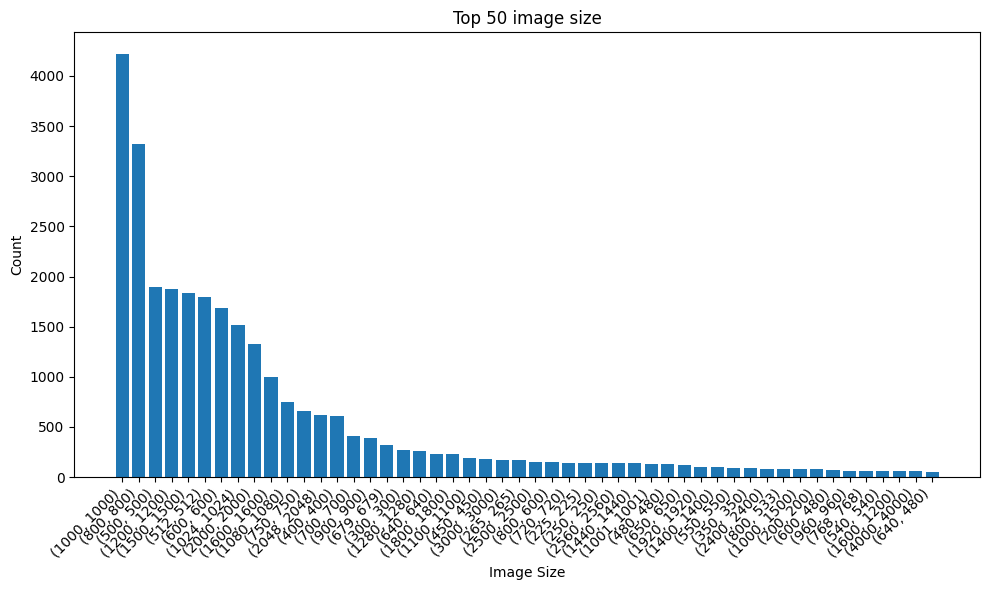

In [7]:
count_and_plot_top_n(dataset, lambda p: (p.get('product_image').width, p.get('product_image').height), field_label='image size', n=50)

The distribution of the number of visual tokens is:

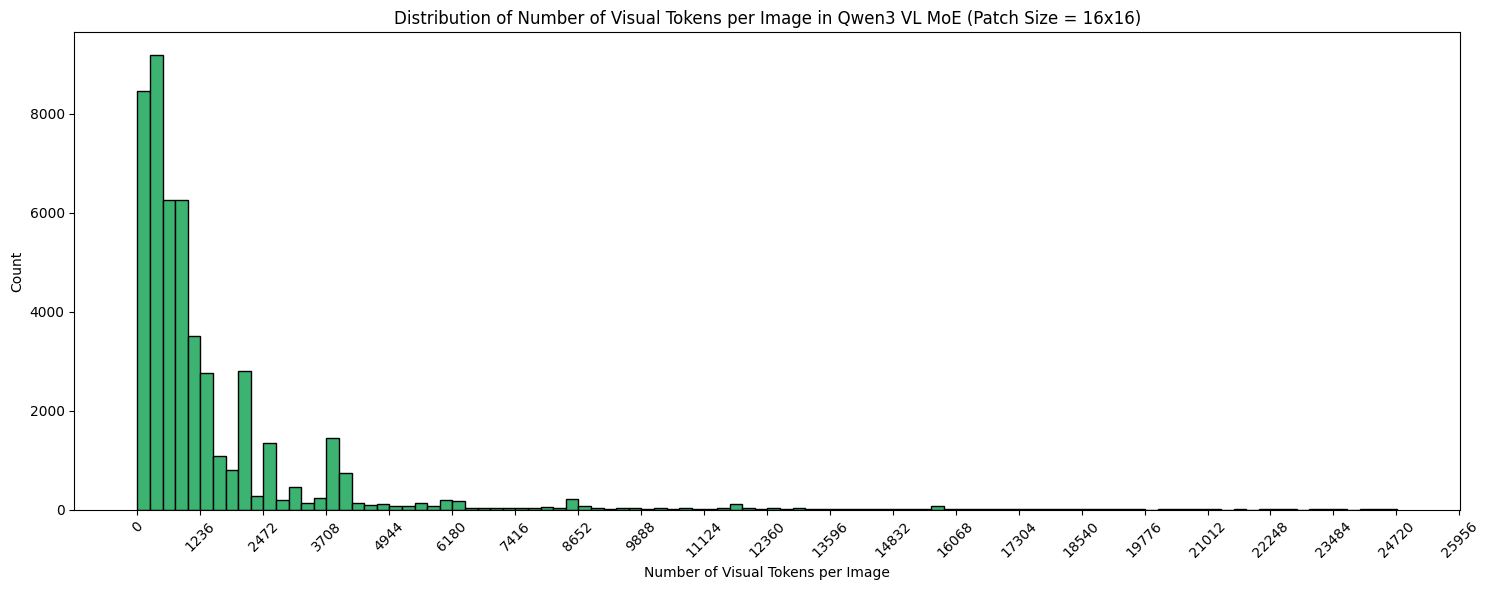

In [19]:
def get_num_visual_tokens(sample, patch_size=16, spatial_merge_size=2):
    return (sample['product_image'].width // patch_size // spatial_merge_size) * (sample['product_image'].height // patch_size // spatial_merge_size)

def plot_visual_tokens_distribution(dataset, patch_size=16, spatial_merge_size=2):
    num_visual_tokens = [get_num_visual_tokens(p, patch_size=patch_size, spatial_merge_size=spatial_merge_size) for p in dataset if p.get('product_image') is not None]

    plt.figure(figsize=(15,6))
    hist_vals, bin_edges, _ = plt.hist(num_visual_tokens, bins=100, color='mediumseagreen', edgecolor='black')
    plt.title(f"Distribution of Number of Visual Tokens per Image in Qwen3 VL MoE (Patch Size = {patch_size}x{patch_size})")
    plt.xlabel("Number of Visual Tokens per Image")

    tick_step = int((max(num_visual_tokens) - min(num_visual_tokens)) / 20)  # 20 ticks
    if tick_step > 0:
        ticks = np.arange(min(num_visual_tokens), max(num_visual_tokens) + tick_step, tick_step)
        plt.xticks(ticks, rotation=45)

    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_visual_tokens_distribution(dataset)

The image file formats are:

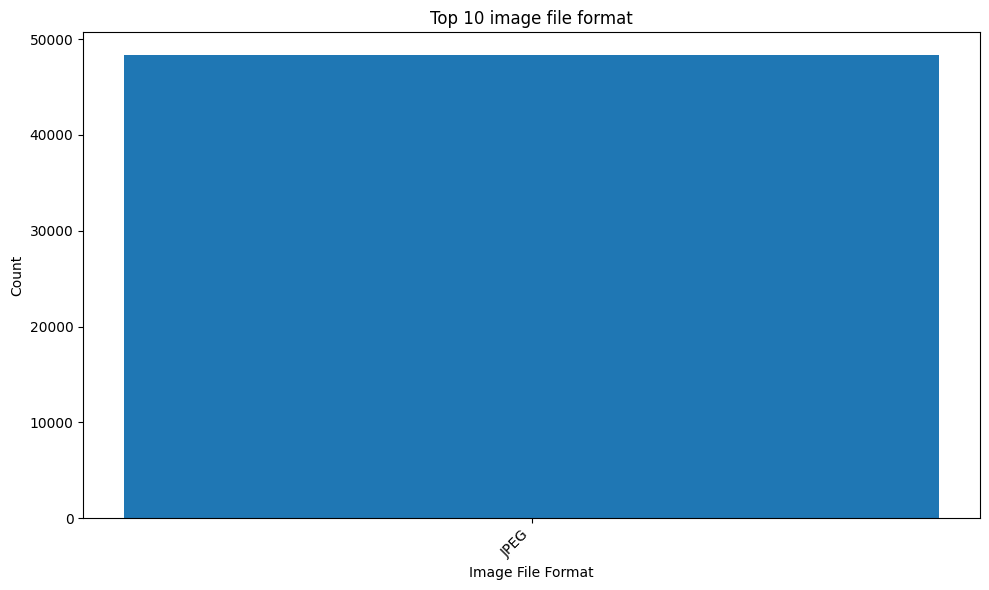

In [9]:
count_and_plot_top_n(dataset, lambda p: p['product_image'].format, field_label='image file format', n=10)

The product descriptions of some samples might contain source code (e.g., javascript, css, html, etc.).

idx 3158 description might contain code
description: Vliesové kompresy nesterilní 10×10 cm, 4vrstvé – 100 ks jsou jemné, savé a hygienické zdravotnické pomůcky určené pro každodenní ošetřování pokožky a ran. Díky čtyřvrstvé struktuře dobře absorbují tekutiny a zároveň zůstávají příjemné na dotek. Jsou vhodné pro použití v ordinacích, kosmetických salonech i v domácí péči a jako jednorázové řešení zajišťují vysoký hygienický standard. VÝHODY 4vrstvá struktura – vysoká savost a tvarová stabilita Velmi jemné k pokožce – vhodné i pro citlivou a podrážděnou pleť Univerzální použití – medicína, kosmetika, domácí péče Jednorázové provedení – zaručuje hygienu a bezpečnost Balení 100 ks – ekonomické pro provozy a pravidelné použití POUŽITÍ Čištění a ošetření ran, odřenin a podrážděné pokožky Dezinfekce pokožky před injekční aplikací Kosmetické a hygienické úkony (peeling, odstraňování masek, tonizace) Péče o miminka a dlouhodobě ležící pacienty Vhodné pro zdravotnická zařízení, salony i domácí 
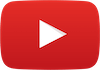

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-VL-30B-A3B-Instruct")

for idx, sample in enumerate(dataset):
    text = sample["product_description"]
    tokens = tokenizer.encode(text, add_special_tokens=False)
    if ("function (" in text and "{" in text) or len(tokens) > 8192:
        print(f"idx {idx} description might contain code")
        print(f"description: {text}")

The distribution of the number of text token is:

In [ ]:
from mlperf_inf_mm_q3vl.task import ProductMetadata

def build_messages(sample):
    image_file = BytesIO()
    image_format = sample["product_image"].format
    sample["product_image"].save(image_file, format=image_format)
    image_bytes = image_file.getvalue()
    image_base64 = base64.b64encode(image_bytes)
    image_base64_string = image_base64.decode("utf-8")
    return [
            {
                "role": "system",
                "content": f"""Please analyze the product from the user prompt
and provide the following fields in a valid JSON object:
- category
- brand
- is_secondhand

You must choose only one, which is the most appropriate, correct, and specifc
category out of the list of possible product categories.

The description of the product sometimes contains various types of source code 
(e.g., JavaScript, CSS, HTML, etc.), where useful product information is embedded 
somewhere inside the source code. For this task, you should extract the useful
product information from the source code and leverage it, and discard the 
programmatic parts of the source code.

Your response should only contain a valid JSON object and nothing more, e.g.,
you should not fence the JSON object inside a ```json code block.
The JSON object should match the followng JSON schema:
```json
{json.dumps(ProductMetadata.model_json_schema(), indent=2)}
```
""",
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"""The title of the product is the following:
```text
{sample['product_title']}
```

The description of the product is the following:
```text
{sample['product_description']}
```

The following are the possible product categories:
```json
{sample['potential_product_categories']}
```
""",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/{image_format};base64,"
                            f"{image_base64_string}",
                        },
                    },
                ],
            },
        ]

def get_num_text_tokens(sample):
    messages = build_messages(sample)
    tokens = tokenizer.apply_chat_template(messages, tokenize=True)
    return len(tokens)


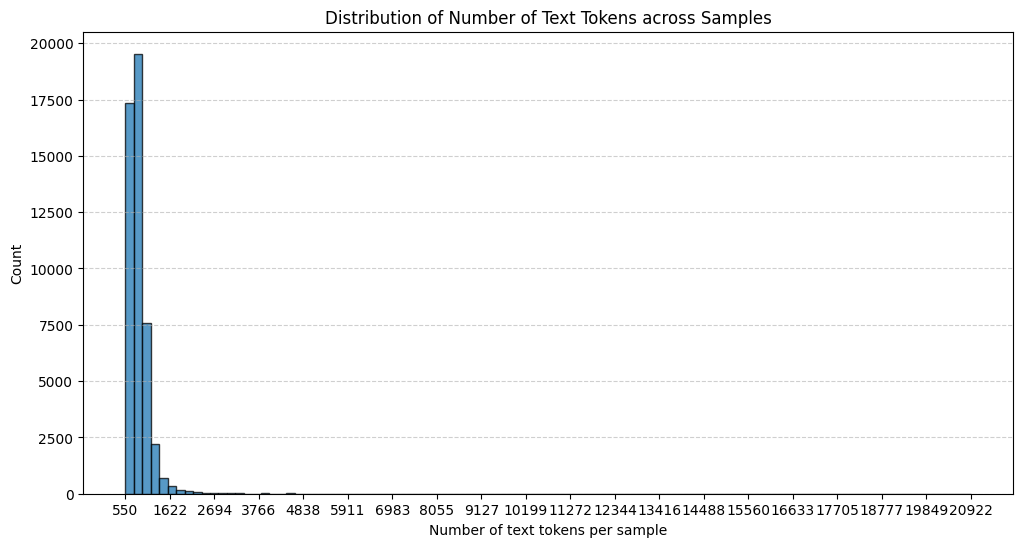

In [21]:
def plot_text_token_histogram(dataset):
    """
    Plot a histogram for the distribution of the number of text tokens across samples in the dataset.
    """
    text_token_counts = [get_num_text_tokens(sample) for sample in dataset]
    plt.figure(figsize=(12, 6))
    n_bins = 100
    plt.hist(text_token_counts, bins=n_bins, edgecolor='black', alpha=0.75)
    plt.xlabel("Number of text tokens per sample")
    plt.ylabel("Count")
    plt.title("Distribution of Number of Text Tokens across Samples")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    # Add 20 x-ticks, evenly spaced within the range
    min_tokens = min(text_token_counts)
    max_tokens = max(text_token_counts)
    xticks = np.linspace(min_tokens, max_tokens, 20)
    plt.xticks(xticks.astype(int))
    plt.show()

plot_text_token_histogram(dataset)

The distribution of the total number of tokens (text + visual):

The longest sample is at index 17035 and has 27051 tokens


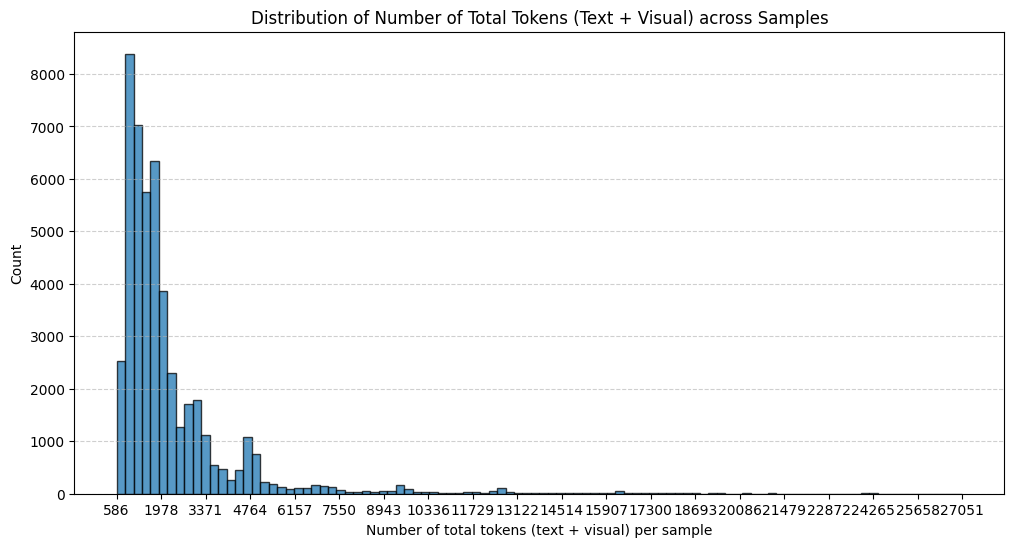

In [26]:
def get_num_total_tokens(sample):
    return get_num_text_tokens(sample) + get_num_visual_tokens(sample)

def plot_total_token_histogram(dataset):
    """
    Plot a histogram for the distribution of the total number of tokens (text + visual) per sample in the dataset.
    """
    total_token_counts = [get_num_total_tokens(sample) for sample in dataset]
    print(f"The longest sample is at index {np.argmax(total_token_counts)} and has {total_token_counts[np.argmax(total_token_counts)]} tokens")
    plt.figure(figsize=(12, 6))
    n_bins = 100
    plt.hist(total_token_counts, bins=n_bins, edgecolor='black', alpha=0.75)
    plt.xlabel("Number of total tokens (text + visual) per sample")
    plt.ylabel("Count")
    plt.title("Distribution of Number of Total Tokens (Text + Visual) across Samples")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    min_tokens = min(total_token_counts)
    max_tokens = max(total_token_counts)
    xticks = np.linspace(min_tokens, max_tokens, 20)
    plt.xticks(xticks.astype(int))
    plt.show()

plot_total_token_histogram(dataset)


Send an example request to a VLM endpoint and get the response:

In [29]:
async def example_query(async_openai_api_client, sample):
    messages = build_messages(sample)
    tic = time.perf_counter()
    print(f"Send query to the VLM endpoint for sample {sample}")
    response = await async_openai_api_client.chat.completions.create(
        model="Qwen/Qwen3-VL-30B-A3B-Instruct",
        messages=messages,
    )
    toc = time.perf_counter()
    print(f"Time taken: {toc - tic} seconds for a sample with {response.usage} tokens; response: {response.choices[0].message.content}")

openai_api_client = AsyncOpenAI(
    api_key="",
    base_url="http://localhost:8000/v1",
    http_client=DefaultAioHttpClient(),
)

In [35]:
query_interval = 1

event_loop, event_loop_thread = Task._create_event_loop_in_separate_thread()

for idx in (17035, 36905):
    time.sleep(query_interval)
    asyncio.run_coroutine_threadsafe(
        example_query(openai_api_client, dataset[idx]),
        event_loop,
    )

Send query to the VLM endpoint for sample {'product_title': 'Insta360 X5 360 Action Camera', 'product_description': 'X5 is the new flagship 360° camera from Insta360, with 8K 360° video and enhanced low light performance for all-day, all-angle shooting. Improved audio, 180-min battery life, and user-replaceable lenses make it the most durable 360° camera yet. A new mode captures flat and 360° video simultaneously—instant .mp4 for sharing, plus 360° footage to reframe later. X5 is an instant classic, perfect for action, content creation, and everyday life. 8K 360° Video | New 1/1.28" Sensors Larger sensors deliver our best ever 8K 360° video. Shoot first, frame later with exceptional image quality, plus the iconic invisible selfie. Triple AI Chip & PureVideo for Superior Low Light X5 takes 360° night shooting to a new level with unprecedented detail and clarity. Powered by new sensors; a Triple AI Chip; and PureVideo, a dedicated low light shooting mode. InstaFrame Mode The new way to s

Time taken: 19.985686069121584 seconds for a sample with CompletionUsage(completion_tokens=42, prompt_tokens=19101, total_tokens=19143, completion_tokens_details=None, prompt_tokens_details=None) tokens; response: {"category": "Cameras & Optics > Cameras > Digital Cameras > 360-Degree Digital Cameras", "brands": ["Insta360"], "is_secondhand": false}
Time taken: 18.995187720982358 seconds for a sample with CompletionUsage(completion_tokens=50, prompt_tokens=17937, total_tokens=17987, completion_tokens_details=None, prompt_tokens_details=None) tokens; response: {"category": "Sporting Goods > Fitness & General Exercise Equipment > Cardio > Cardio Machine Accessories & Parts > Treadmill Accessories & Parts > Treadmill Belts", "brands": ["Life Fitness"], "is_secondhand": false}
